In [1]:
import os
import argparse
import random

import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

import kmeans_pytorch 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import ot
import pickle
from einops import repeat, rearrange
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data import Dataset, DataLoader, ConcatDataset


from DRUPE.models.simclr_model import SimCLR
from DRUPE.datasets import  get_dataset_evaluation
from DRUPE.datasets.cifar10_dataset import get_shadow_cifar10, get_downstream_cifar10
from DRUPE.datasets.gtsrb_dataset import get_shadow_gtsrb
# from DRUPE.evaluation import create_torch_dataloader, NeuralNet, net_train, net_test_with_logger, predict_feature
from utils import create_torch_dataloader, NeuralNet, net_train, net_test, predict_feature

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= '1' #args.gpu

2024-11-22 12:52:44.040170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 12:52:44.189182: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-22 12:52:44.189207: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


 # Attacks Preparations
 Use one type of attack before using defense method

 ## BadEncoder

Namespace(batch_size=256, batch_size_downstream=64, data_dir='./data/cifar10/', downstream_dataset='cifar10', encoder_usage_info='cifar10', epochs=120, gpu='1', hidden_size_1=512, hidden_size_2=256, knn_k=200, knn_t=0.5, lambda1=1.0, lambda2=1.0, lr=0.05, lr_downstream=0.0001, mask_ratio=0.75, mode='badencoder', n_ref=3, nn_epochs=500, pretrained_encoder='./output/cifar10/clean_encoder/model_1000.pth', pretraining_dataset='cifar10', reference_file='./reference/gtsrb_l12_n3.npz', reference_label=0, results_dir='./DRUPE_results/badencoder/pretrain_cifar10_sf0.2/downstream_cifar10_t0/', seed=100, shadow_dataset='cifar10', shadow_fraction=0.2, target_label=0, trigger_file='./trigger/trigger_pt_white_21_10_ap_replace.npz')
[ 4253 30076 48047 ... 22804 45637 31550]
loading from the training data
self.target_image_list.shape (3, 32, 32, 3)
10000 50000 10000


/tmp/ipykernel_386219/49715264.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args.results_dir +'epoch120.pth')
100%|██████████████████████████

torch.Size([10880, 512]) torch.Size([10880])
(10880, 2)


/tmp/ipykernel_386219/49715264.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'][label==0] = 'clean'


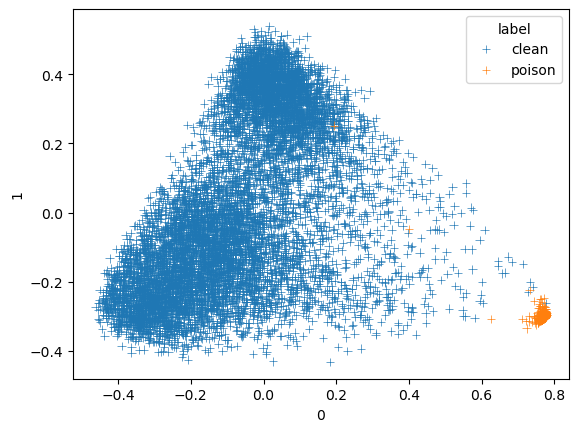

In [2]:
with open('./DRUPE/args_badencoder.pkl', 'rb') as handle:
    args = pickle.load(handle)
print(args)
args.data_dir = './data/cifar10/'
args.trigger_file = './DRUPE/trigger/trigger_pt_white_21_10_ap_replace.npz'
args.reference_file = './DRUPE/reference/cifar10_l0.npz'
# args.results_dir = './DRUPE/DRUPE_results/badencoder/pretrain_cifar10_sf0.2/downstream_cifar10_t12/'
args.results_dir = 'DEDE_results/badencoder_epoch120.pth'
args.dataset = args.downstream_dataset

shadow_data, memory_data, test_data_clean, test_data_backdoor = get_shadow_cifar10(args)
print(len(shadow_data),len(memory_data), len(test_data_clean))

model = SimCLR().cuda()
checkpoint = torch.load(args.results_dir +'epoch120.pth')
# checkpoint = torch.load('./DRUPE/output/cifar10/clean_encoder/model_last.pth') # clean model
model.load_state_dict(checkpoint['state_dict'], strict=False)
backdoored_encoder = model.f

poison_rate =  0.1
subset_test_data_backdoor,_ = torch.utils.data.random_split(test_data_backdoor, [poison_rate, 1-poison_rate])
test_data = ConcatDataset([test_data_clean, subset_test_data_backdoor])
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=16, 
                                  pin_memory=True, drop_last=True)

model.eval()
with torch.no_grad():
    feature_bank = []
    target_bank = []
    
    test_bar = tqdm(test_loader)
    for data, target in test_bar:
        data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
        feature, out = model(data)
        
        target_bank.append(target)
        feature_bank.append(feature)
        
    feature_bank = torch.cat(feature_bank, dim=0).contiguous()
    target_bank = torch.cat(target_bank, dim=0).contiguous()

print(feature_bank.shape, target_bank.shape) 
feature_bank = feature_bank.detach().cpu().numpy()
target_bank = target_bank.detach().cpu().numpy()
lbs, counts = np.unique(target_bank, return_counts=True)


bd_labels = np.append(np.zeros(len(test_data_clean)), np.ones(len(subset_test_data_backdoor)))

### dimension reduction
# tsne = TSNE(n_components=2, init='pca', random_state=0)
# result = tsne.fit_transform(feature_bank)
pca = PCA(n_components=2)
result = pca.fit_transform(feature_bank)

print(result.shape)

label = bd_labels[:result.shape[0]]

df = pd.DataFrame(result)
df['label'] = label
df['label'][label==0] = 'clean'
df['label'][label==1] = 'poison'
# df['label'][target_bank==9] = 'target class'
df.head()

sns.scatterplot(data=df, x=0, y=1, hue="label", marker="+")
plt.savefig('./plot_result/badencoder.jpg', dpi=350, bbox_inches='tight')
plt.show()

## DRUPE

In [ ]:
with open('./DRUPE/args_drupe.pkl', 'rb') as handle:
    args = pickle.load(handle)
print(args)
args.seed = 21
args.data_dir = './data/cifar10/'
args.trigger_file = './DRUPE/trigger/trigger_pt_white_21_10_ap_replace.npz'
args.reference_file = './DRUPE/reference/cifar10_l0.npz'
# args.results_dir = './DRUPE/DRUPE_results/drupe/pretrain_cifar10_sf0.2/downstream_cifar10_t12/'
args.results_dir = 'DEDE_results/drupe_epoch120.pth'

model = SimCLR().cuda()
checkpoint = torch.load(args.results_dir +'epoch120.pth')
model.load_state_dict(checkpoint['state_dict'], strict=False)
backdoored_encoder = model.f

shadow_data, memory_data, test_data_clean, test_data_backdoor = get_shadow_cifar10(args)
print(len(shadow_data),len(memory_data), len(test_data_clean))

poison_rate =  0.1
subset_test_data_backdoor,_ = torch.utils.data.random_split(test_data_backdoor, [poison_rate, 1-poison_rate])
test_data = ConcatDataset([test_data_clean, subset_test_data_backdoor])
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=16, 
                                  pin_memory=True, drop_last=True)

model.eval()
with torch.no_grad():
    feature_bank = []
    target_bank = []
    
    test_bar = tqdm(test_loader)
    for data, target in test_bar:
        data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
        feature, out = model(data)
        
        target_bank.append(target)
        feature_bank.append(feature)
        
    feature_bank = torch.cat(feature_bank, dim=0).contiguous()
    target_bank = torch.cat(target_bank, dim=0).contiguous()

print(feature_bank.shape, target_bank.shape) 
feature_bank = feature_bank.detach().cpu().numpy()
target_bank = target_bank.detach().cpu().numpy()
lbs, counts = np.unique(target_bank, return_counts=True)

bd_labels = np.append(np.zeros(len(test_data_clean)), np.ones(len(subset_test_data_backdoor)))

# dimension reduction
# tsne = TSNE(n_components=2, init='pca', random_state=0)
# result = tsne.fit_transform(feature_bank)
pca = PCA(n_components=2)
result = pca.fit_transform(feature_bank)

print(result.shape)

label = bd_labels[:result.shape[0]]

df = pd.DataFrame(result)
df['label'] = label
df['label'][label==0] = 'clean'
df['label'][label==1] = 'poison'
# df['label'][target_bank==9] = 'target class'
df.head()

sns.scatterplot(data=df, x=0, y=1, hue="label", marker="+")
plt.savefig('./plot_result/drupe.jpg',  dpi=350, bbox_inches='tight')
plt.show()

## CTRL

python main_train.py --dataset cifar10 --data_path '../data/' --mode frequency --method simclr --threat_model our \
--channel 1 2 --trigger_position 15 31 --poison_ratio 0.01 --lr 0.06 --wd 0.0005 --magnitude 100.0 \
--poisoning --epochs 100 --gpu 1 --window_size 32


In [ ]:
from CTRL.methods import set_model
from CTRL.loaders.diffaugment import set_aug_diff, PoisonAgent
from CTRL.utils.frequency import PoisonFre
import utils

with open('./CTRL/args.pkl', 'rb') as handle:
    args = pickle.load(handle)
print(args)
args.data_path = './data/'
args.poison_ratio = 0.99
args.threat_model = 'our'
args.gpu = '0'

model = set_model(args).cuda()
checkpoint = torch.load('./CTRL/Experiments/cifar10-simclr-resnet18-0.01-100.0-512-0.06-False-our-0/' 
                        +'epoch_81.pth.tar', map_location='cpu')
model.load_state_dict(checkpoint['state_dict'], strict=False)
backdoored_encoder = model.backbone

train_loader, train_sampler, train_dataset, ft_loader, ft_sampler, test_loader, test_dataset, memory_loader, train_transform, ft_transform, test_transform = set_aug_diff(args)
img = test_dataset[99][0]
img = img.permute(1, 2, 0)
plt.imshow(img, cmap='hot')
print(test_dataset[99][1])

poison_frequency_agent = PoisonFre(args, args.size, args.channel, args.window_size, args.trigger_position,  False,  True)
poison = PoisonAgent(args, poison_frequency_agent, train_dataset, test_dataset, memory_loader, args.magnitude)
test_pos_loader = poison.test_pos_loader

test_data_clean = test_dataset
test_data_backdoor = test_pos_loader.dataset


test_data_clean = utils.DummyDataset(test_data_clean,transform=utils.test_transform)
test_data_backdoor = utils.DummyDataset(test_data_backdoor,transform=utils.test_transform)

In [ ]:
poison_rate =   0.1
subset_test_data_backdoor,_ = torch.utils.data.random_split(test_data_backdoor, [poison_rate, 1-poison_rate])
test_data = ConcatDataset([test_data_clean, subset_test_data_backdoor])
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=16, 
                                  pin_memory=True, drop_last=True)
print(len(test_loader)*128)

model.eval()
with torch.no_grad():
    feature_bank = []
    target_bank = []
    
    test_bar = tqdm(test_loader)
    for data, target, _ in test_bar:
        data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
        feature = backdoored_encoder(data)
        
        target_bank.append(target)
        feature_bank.append(feature)
        
    feature_bank = torch.cat(feature_bank, dim=0).contiguous()
    target_bank = torch.cat(target_bank, dim=0).contiguous()

print(feature_bank.shape, target_bank.shape) 
feature_bank = feature_bank.detach().cpu().numpy()
target_bank = target_bank.detach().cpu().numpy()
print(np.unique(target_bank, return_counts=True))


bd_labels = np.append(np.zeros(len(test_data_clean)), np.ones(len(subset_test_data_backdoor)))

# dimension reduction
# tsne = TSNE(n_components=2, init='pca', random_state=0)
# result = tsne.fit_transform(feature_bank)
pca = PCA(n_components=2)
result = pca.fit_transform(feature_bank)

print(result.shape)

label = bd_labels[:result.shape[0]]

df = pd.DataFrame(result)
df['label'] = label
df['label'][label==0] = 'clean'
df['label'][label==1] = 'poison'
# df['label'][target_bank==9] = 'target class'
df.head()

sns.scatterplot(data=df, x=0, y=1, hue="label", marker="+")
plt.savefig('./plot_result/ctrl.jpg', dpi=260)
plt.show()

## CLIP-Backdoor (Google)

In [ ]:
from DECREE.imagenet import getBackdoorImageNet, get_processing
from DECREE.models import get_encoder_architecture_usage
from DECREE.clip import clip

parser = argparse.ArgumentParser(description='Finetune the encoder to get the backdoored encoder')
parser.add_argument('-f')
args = parser.parse_args()

args.encoder_usage_info = 'CLIP'
args.reference_type = 'text'
args.shadow_dataset = 'imagenet'
args.data_dir = f'./DECREE/data/{args.shadow_dataset.split("_")[0]}/'
args.trigger_file = './DECREE/trigger/' + 'trigger_pt_white_185_24.npz'
args.reference_word = 'truck'
args.reference_type = 'text'
args.pretrained_encoder = f'./DECREE/output/CLIP_text/cifar10_backdoored_encoder/model_69clip_text_atk0.05_41.pth'
args.batch_size = 128

train_transform, _ = get_processing('imagenet', augment=True)
test_transform, _ = get_processing('imagenet', augment=False)
shadow_data = getBackdoorImageNet(
                trigger_file=args.trigger_file,
                train_transform=test_transform,
                test_transform=test_transform,
                reference_word=args.reference_word,
                poison_rate=0.2)
clean_clip, preprocess = clip.load("RN50")

print(f'shadow datasize: {len(shadow_data)}')
train_loader = DataLoader(shadow_data, batch_size=args.batch_size, 
                            shuffle=False, num_workers=8, 
                            pin_memory=True, drop_last=True)

model = get_encoder_architecture_usage(args).cuda()

checkpoint = torch.load(args.pretrained_encoder, map_location='cpu', weights_only=True)
model.visual.load_state_dict(checkpoint['state_dict'])

backdoored_encoder = model.visual

test_data_clean = utils.CIFAR10_BACKDOOR_CLIP(root='./data', train=False, trigger_file=args.trigger_file,
                                     test_transform=utils.test_transform224, poison_rate=0, lb_flag='')
test_data_backdoor = utils.CIFAR10_BACKDOOR_CLIP(root='./data', train=False, trigger_file=args.trigger_file,
                                     test_transform=utils.test_transform224, poison_rate=1, lb_flag='')

# img = test_data_clean[77][0]
# img = img.permute(1, 2, 0)
# plt.imshow(img, cmap='hot')
# plt.show()

img = test_data_backdoor[77][0]
img = img.permute(1, 2, 0)
plt.imshow(img, cmap='hot')
plt.show()

In [ ]:
poison_rate =  0.1
subset_test_data_backdoor,_ = torch.utils.data.random_split(test_data_backdoor, [poison_rate, 1-poison_rate])
test_data = ConcatDataset([test_data_clean, subset_test_data_backdoor])
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=16, 
                                  pin_memory=True, drop_last=True)

backdoored_encoder.eval()
with torch.no_grad():
    feature_bank = []
    target_bank = []
    
    test_bar = tqdm(test_loader)
    for data, target in test_bar:
        data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
        feature = backdoored_encoder(data)
        
        target_bank.append(target)
        feature_bank.append(feature)
        
    feature_bank = torch.cat(feature_bank, dim=0).contiguous()
    target_bank = torch.cat(target_bank, dim=0).contiguous()

print(feature_bank.shape, target_bank.shape) 
feature_bank = feature_bank.detach().cpu().numpy()
target_bank = target_bank.detach().cpu().numpy()
np.unique(target_bank, return_counts=True)

bd_labels = np.append(np.zeros(len(test_data_clean)), np.ones(len(subset_test_data_backdoor)))

# dimension reduction
# tsne = TSNE(n_components=2, init='pca', random_state=0)
# result = tsne.fit_transform(feature_bank)
pca = PCA(n_components=2)
result = pca.fit_transform(feature_bank)

print(result.shape)

label = bd_labels[:result.shape[0]]

df = pd.DataFrame(result)
df['label'] = label
df['label'][label==0] = 'clean'
df['label'][label==1] = 'poison'
# df['label'][target_bank==9] = 'target class'
df.head()

sns.scatterplot(data=df, x=0, y=1, hue="label", marker="+")
plt.savefig('./plot_result/clipgoogle.jpg', dpi=260)
plt.show()

## BadCLIP

In [ ]:
from BadCLIP.pkgs.openai.clip import load as load_model
from BadCLIP.backdoor.utils import apply_trigger

model, processor = load_model(name = 'RN50', pretrained = False)
model.cuda()
state_dict = model.state_dict()

checkpoint  = torch.load('./BadCLIP/logs/nodefence_ours_final/checkpoints/epoch_10.pt', map_location = 'cpu', weights_only=False)
state_dict_load  = checkpoint["state_dict"]
assert len(state_dict.keys()) == len(state_dict_load.keys())
for i in range(len(state_dict.keys())):
    key1 = list(state_dict.keys())[i]
    key2 = list(state_dict_load.keys())[i]
    assert key1 in key2
    state_dict[key1] = state_dict_load[key2]

model.load_state_dict(state_dict)
backdoored_encoder = model.visual

memory_data = utils.CIFAR10_BACKDOOR_BadCLIP(root='./data', train=True, trigger_file='',
                                     test_transform=utils.test_transform224, poison_rate=0, lb_flag='')

test_data_clean = utils.CIFAR10_BACKDOOR_BadCLIP(root='./data', train=False, trigger_file='',
                                     test_transform=utils.test_transform224, poison_rate=0, lb_flag='')
test_data_backdoor = utils.CIFAR10_BACKDOOR_BadCLIP(root='./data', train=False, trigger_file='',
                                     test_transform=utils.test_transform224, poison_rate=1, lb_flag='')

# img = test_data_clean[99][0]
# img = img.permute(1, 2, 0)
# plt.imshow(img, cmap='hot')
# plt.show()

img = test_data_backdoor[99][0]
img = img.permute(1, 2, 0)
plt.imshow(img, cmap='hot')
plt.show()

In [ ]:
poison_rate =  0.1
subset_test_data_backdoor,_ = torch.utils.data.random_split(test_data_backdoor, [poison_rate, 1-poison_rate])
test_data = ConcatDataset([test_data_clean, subset_test_data_backdoor])
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=16, 
                                  pin_memory=True, drop_last=True)

backdoored_encoder.eval()
with torch.no_grad():
    feature_bank = []
    target_bank = []
    
    test_bar = tqdm(test_loader)
    for data, target in test_bar:
        data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
        feature = backdoored_encoder(data)
        
        target_bank.append(target)
        feature_bank.append(feature)
        
    feature_bank = torch.cat(feature_bank, dim=0).contiguous()
    target_bank = torch.cat(target_bank, dim=0).contiguous()

print(feature_bank.shape, target_bank.shape) 
feature_bank = feature_bank.detach().cpu().numpy()
target_bank = target_bank.detach().cpu().numpy()
lbs, _ = np.unique(target_bank, return_counts=True)

bd_labels = np.append(np.zeros(len(test_data_clean)), np.ones(len(subset_test_data_backdoor)))

# dimension reduction
# tsne = TSNE(n_components=2, init='pca', random_state=0)
# result = tsne.fit_transform(feature_bank)
pca = PCA(n_components=2)
result = pca.fit_transform(feature_bank)

print(result.shape)

label = bd_labels[:result.shape[0]]

df = pd.DataFrame(result)
df['label'] = label
df['label'][label==0] = 'clean'
df['label'][label==1] = 'poison'
# df['label'][target_bank==9] = 'target class'
df.head()

sns.scatterplot(data=df, x=0, y=1, hue="label", marker="+")
plt.savefig('./plot_result/badclip.jpg',dpi=350, bbox_inches='tight')
plt.show()

# Detection with DEDE

In [3]:
from decoder_model import DecoderModel
from utils import MAE_test, MAE_error

tag = 'badencoder_mask9_patch4_ood'
result_dir = './DEDE_results/'+tag

with open(result_dir+'/args.pkl', 'rb') as handle:
    args = pickle.load(handle)

In [ ]:
tag = 'drupe_mask9_patch4_ood'
result_dir = './DEDE_results/'+tag
with open(result_dir+'/args.pkl', 'rb') as handle:
    args = pickle.load(handle)

In [ ]:
tag = 'ctrl_enc4_mask75_patch4_id'
result_dir = './DEDE_results/'+tag
with open(result_dir+'/args.pkl', 'rb') as handle:
    args = pickle.load(handle)

In [ ]:
tag = 'clip_mask9_patch4_ood'
result_dir = './DEDE_results/'+tag
with open(result_dir+'/args.pkl', 'rb') as handle:
    args = pickle.load(handle)

In [ ]:
tag = 'badclip_mask75_patch32_ood'
result_dir = './DEDE_results/'+tag
with open(result_dir+'/args.pkl', 'rb') as handle:
    args = pickle.load(handle)

/tmp/ipykernel_386219/871921564.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(result_dir +'/final.pth' , map_location='cpu')


torch.Size([256, 192, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 192, 3])


,0,1
0,1877.565186,10517.967773
1,2463.748779,8948.572266
2,1063.432373,6240.940918
3,2266.273193,5730.636719
4,2403.574219,9694.708984
5,1152.264404,9102.238281
6,3808.041260,12961.625000
7,947.245972,11803.367188
8,1594.629272,5429.978516
9,2338.480469,4715.259766


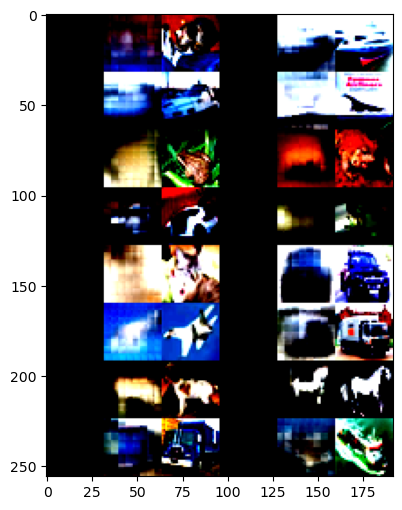

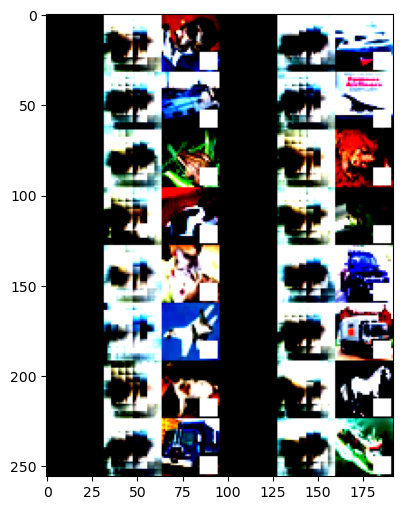

In [4]:
args.mask_ratio = 0.99 # test time

if args.attack_type=='clip' or args.attack_type=='badclip':
    print("assert clip")
    args.arch = 'CLIP' # assert
    args.image_size = 224 # assert
    model = DecoderModel(image_size=args.image_size, 
                         patch_size=args.patch_size, mask_ratio=args.mask_ratio, 
                         encoder_layer=args.encoder_layer, decoder_layer=args.decoder_layer, 
                         arch=args.arch).cuda()
else:
    model = DecoderModel(patch_size = args.patch_size, mask_ratio=args.mask_ratio,
                                 encoder_layer=args.encoder_layer, decoder_layer=args.decoder_layer).cuda()

# rewrite here as needed, load our model
checkpoint = torch.load(result_dir +'/final.pth' , map_location='cpu')
checkpoint = torch.load('./DEDE_results/drupe_mask9_patch4_ood_final.pth' , map_location='cpu')
model.load_state_dict(checkpoint['state_dict'], strict=False)

error_record = []

imgc, errors = MAE_test(backdoored_encoder, model, test_data_clean) # test_data_clean) # test_data_backdoor)
error_record.append(errors)
img = imgc.permute(1, 2, 0)
print(img.shape)
img = img.detach().cpu()
plt.figure(figsize=(6,6))
plt.imshow(img, cmap='hot')

imgb, errors = MAE_test(backdoored_encoder, model, test_data_backdoor) # subset_test_data_backdoor)
error_record.append(errors)
img = imgb.permute(1, 2, 0)
print(img.shape)
img = img.detach().cpu()
plt.figure(figsize=(6,6))
plt.imshow(img, cmap='hot')

error = np.array(error_record)
df = pd.DataFrame(error.T)

df.head(15)

In [5]:
error_record = []
_,errors = MAE_error(backdoored_encoder, model, test_data_clean, save_cuda=True)
error_record.append(errors)
_,errors = MAE_error(backdoored_encoder, model, test_data_backdoor, save_cuda=True)#test_data_backdoor , subset_test_data_backdoor
error_record.append(errors)

X = np.concatenate((np.array(error_record[0]),np.array(error_record[1])), axis = 0)
y = [0] * len(error_record[0]) + [1] * len(error_record[1])
df = pd.DataFrame({'errors':X,'bd_label':y})
print(df.shape)

(20000, 2)


/tmp/ipykernel_386219/2989218139.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["backdoor"][df["bd_label"]==0] = "clean"


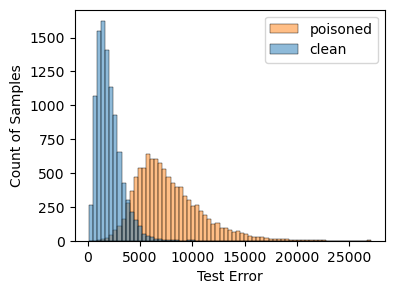

In [6]:
df["backdoor"] = y
df["backdoor"][df["bd_label"]==0] = "clean"
df["backdoor"][df["bd_label"]==1] = "poisoned"
plt.figure(figsize=(4,3))
ax = sns.histplot(data = df, x='errors', hue='backdoor')
plt.ylabel("Count of Samples")
plt.xlabel("Test Error")
plt.legend(title='', loc='upper right', labels=['poisoned', 'clean'])
plt.savefig('./plot_result/hist_dede_{}.jpg'.format(args.attack_type), dpi=350, bbox_inches='tight')
plt.show()

In [7]:
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score

threshold =  df['errors'].median() # df['X'].mean()
df['pred'] = df['errors'] > threshold

fpr, tpr, thresholds = roc_curve(df['bd_label'], df['pred'], pos_label=1)
fpr, tpr, roc_auc_score(df['bd_label'], df['errors'])

(array([0.    , 0.0671, 1.    ]),
 array([0.    , 0.9329, 1.    ]),
 0.9813263099999999)